# Anomaly (novelty) Detection

In [1]:
!pip install pandas numpy matplotlib seaborn scipy pyod scikit-learn

## Load data

In [2]:
import pandas as pd
df = pd.read_csv('data_PdM_errors.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

## EDA
Show data

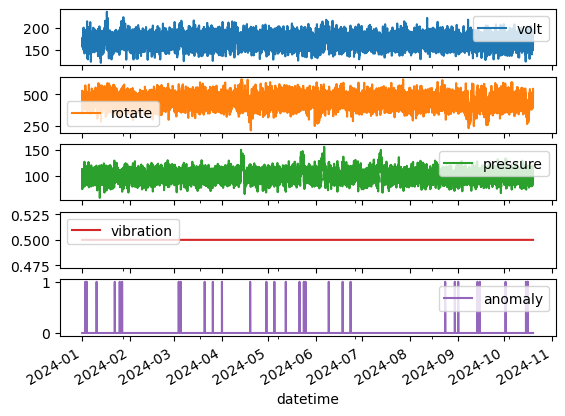

In [3]:
import matplotlib.pyplot as plt  

# showing dataset 
df.plot(x='datetime', kind='line', subplots=True) 
plt.show() 

In [4]:
df['anomaly'].value_counts()

anomaly
0    6967
1      33
Name: count, dtype: int64

In [5]:
# analysis of variance
df_std = df.std()
print(df_std) 

datetime     84 days 11:08:38.785508620
volt                          15.287555
rotate                        52.018896
pressure                      10.819209
vibration                           0.0
anomaly                        0.068504
dtype: object


<Axes: >

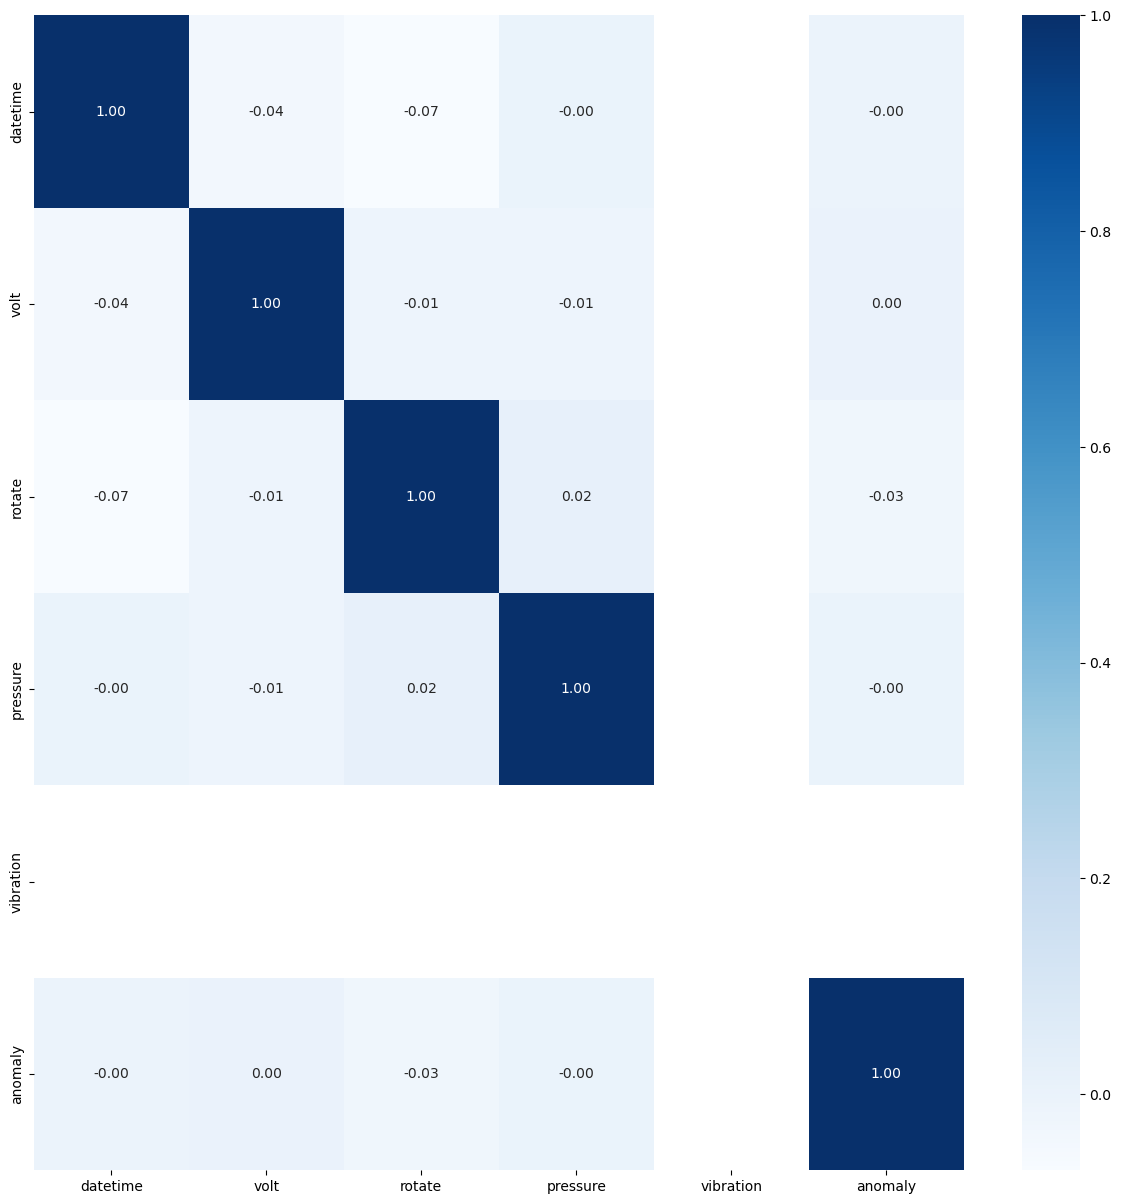

In [6]:
import matplotlib.pyplot as plt
from seaborn import heatmap
plt.figure(figsize=(15, 15))
heatmap(df.corr(),annot=True,cmap='Blues', fmt='.2f')

In [7]:
# separate into input and output variables 
X = df[['volt', 'rotate', 'pressure']].values
y = df[['anomaly']].values.flat

idx_split=6500
X_train, y_train = X[0:idx_split,:], y[0:idx_split]
X_test, y_test = X[idx_split:,:], y[idx_split:]

### Feature selection
USe RFE to select the most important varaible

In [8]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# perform feature selection 
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1))  
rfe = rfe.fit(X, y) 

In [9]:
# report selected features 
print('Selected Features:') 
names = df.columns.values[1:-1] 

for i in range(len(rfe.support_)): 
    if rfe.support_[i]: 
        print(names[i]) 

Selected Features:
rotate


# Build algorithm Moving average
* Moving average
* Id standard deviation is too high => anomaly

In [10]:
import numpy as np

def moving_average(data, window_size): 
    window = np.ones(int(window_size))/float(window_size)  
    return np.convolve(data, window, 'same') 

def search_anomalies(x, window_size, sigma=1.0): 
    avg = moving_average(x, window_size).tolist() 
    residual = x - avg 
    
    # Calculate the variation in the distribution of the residual 
    std = np.std(residual) 

    anomalies=[] 
    i=int(window_size)

    for y_i, avg_i in zip(x, avg): 
        if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std)):  
            anomalies.append(1)
        else:
            anomalies.append(0)
    
    return np.array(anomalies)

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
def show_anomalies(X_test, y_test, y_predicted, anomalous=1, title=''):
    t = np.array([i for i in range(len(y_test))]) 
    
    idx_predicted = y_predicted==anomalous
    idx_real = y_test==anomalous
    
    plt.figure(figsize=(10,5))
    plt.xlabel('samples')
    plt.ylabel(title)
    plt.plot(t,X_test,'tab:gray')
    plt.plot(t[idx_predicted], X_test[idx_predicted],'rD', label="predicted anomaly")
    plt.plot(t[idx_real],X_test[idx_real],'gX', label="real anomaly")
    plt.legend()
    plt.show()

    print('accuracy:',accuracy_score(idx_real,idx_predicted))
    print('confusion matrix:\n',confusion_matrix(idx_real,idx_predicted))

In [12]:
volt = df['volt'].values  
rotate = df['rotate'].values
pressure = df['pressure'].values  
vibration = df['vibration'].values 

anomalies_volt = search_anomalies(volt, window_size=60, sigma=2) 
anomalies_vibration = search_anomalies(vibration, window_size=60, sigma=2)
anomalies_rotate = search_anomalies(rotate, window_size=60, sigma=2) 
anomalies_pressure = search_anomalies(pressure, window_size=60, sigma=2) 

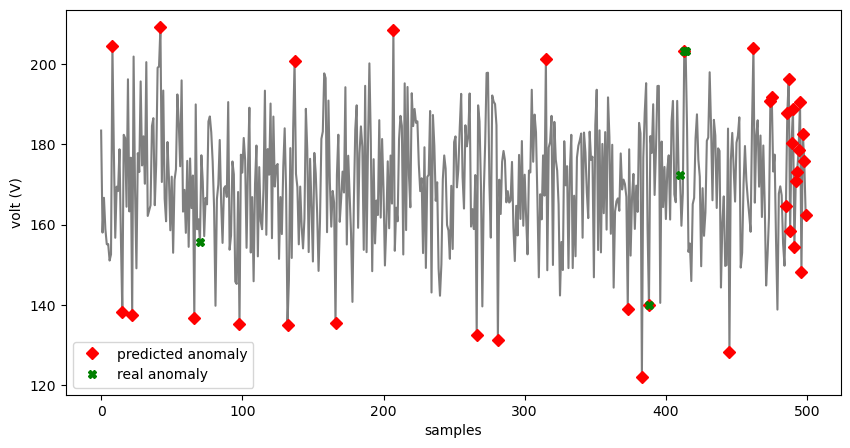

accuracy: 0.926
confusion matrix:
 [[461  34]
 [  3   2]]


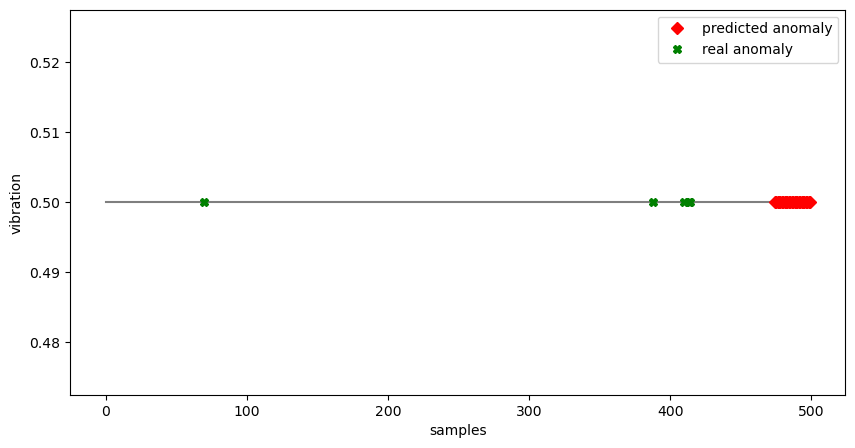

accuracy: 0.938
confusion matrix:
 [[469  26]
 [  5   0]]


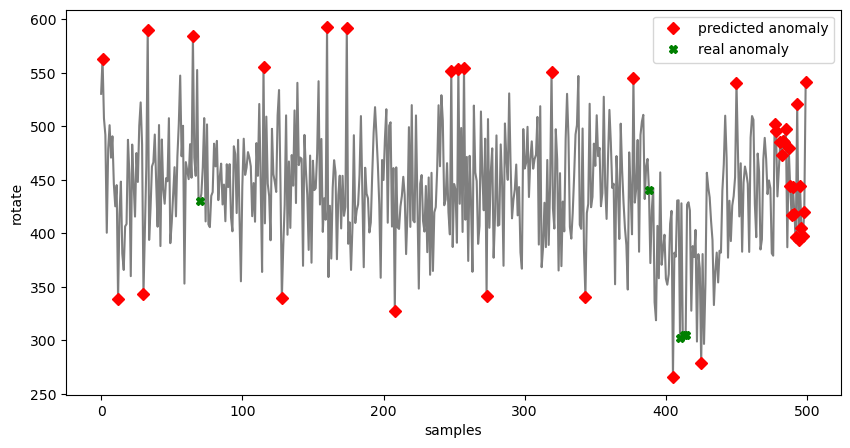

accuracy: 0.91
confusion matrix:
 [[455  40]
 [  5   0]]


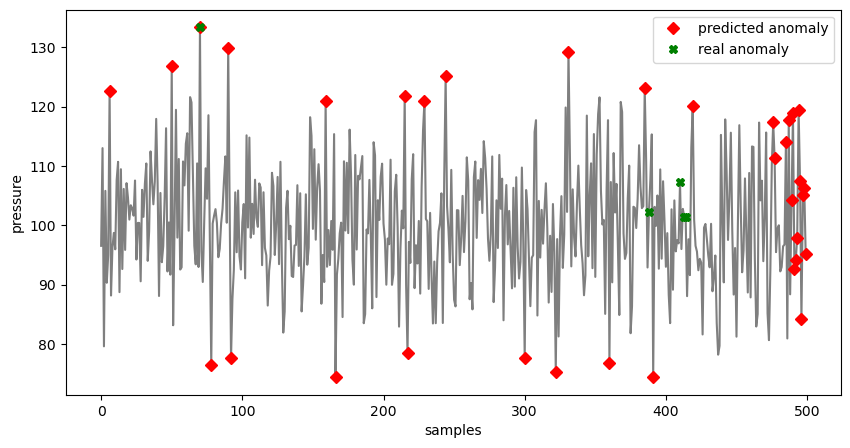

accuracy: 0.926
confusion matrix:
 [[462  33]
 [  4   1]]


In [13]:
#showing results
show_anomalies(volt[idx_split:], y[idx_split:], anomalies_volt[idx_split:], title='volt (V)')
show_anomalies(vibration[idx_split:], y[idx_split:], anomalies_vibration[idx_split:], title='vibration')
show_anomalies(rotate[idx_split:], y[idx_split:], anomalies_rotate[idx_split:], title='rotate')
show_anomalies(pressure[idx_split:], y[idx_split:], anomalies_pressure[idx_split:], title='pressure')
plt.show() 

In [14]:
import numpy as np
def test_search_anomalies():
    data=np.array([10, 10, 10, 10, 30, 20, 10, 10]) 
    predicted=search_anomalies(data, 2)
    assert predicted[1]==0
    assert predicted[4]==1
    assert predicted[5]==1 
test_search_anomalies()

## Version 2 with ML and ARIMA

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
import numpy as np
from sklearn.svm import OneClassSVM
def ARIMA_residuals(series): 
    # fit model 
    model = ARIMA(series, order=(5,1,3)) 
    model_fit = model.fit() 
    print(model_fit.summary()) 
    
    # plot residual errors 
    residuals = pd.DataFrame(model_fit.resid)  
    
    return residuals.T 

  
def search_anomalies_OCSVM(X_train, X_test): 
    clf = OneClassSVM(kernel="rbf", tol=0.0001, nu=0.1).fit(X_train)
    y_pred = clf.predict(X_test) 
    anomalies=[ 0 if _x > 0 else 1 for _x in y_pred] 
    return np.array(anomalies)

In [16]:
#X_residual=np.vstack(( ARIMA_residuals(volt), ARIMA_residuals(rotate), ARIMA_residuals(pressure))).T
X_residual=np.vstack(( ARIMA_residuals(volt), 
             ARIMA_residuals(rotate))).T 
anomalies=search_anomalies_OCSVM(X_residual, X_residual)

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7000
Model:                 ARIMA(5, 1, 3)   Log Likelihood              -28978.623
Date:                Fri, 19 Jul 2024   AIC                          57975.247
Time:                        15:40:25   BIC                          58036.928
Sample:                             0   HQIC                         57996.501
                               - 7000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3244      0.046    -29.071      0.000      -1.414      -1.235
ar.L2         -0.7989      0.046    -17.434      0.000      -0.889      -0.709
ar.L3          0.1811      0.022      8.320      0.0

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7000
Model:                 ARIMA(5, 1, 3)   Log Likelihood              -37458.758
Date:                Fri, 19 Jul 2024   AIC                          74935.516
Time:                        15:40:33   BIC                          74997.198
Sample:                             0   HQIC                         74956.771
                               - 7000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8664      2.247     -0.386      0.700      -5.271       3.538
ar.L2          0.0584      0.380      0.154      0.878      -0.686       0.802
ar.L3          0.0752      0.083      0.904      0.3

(-200.0, 200.0)

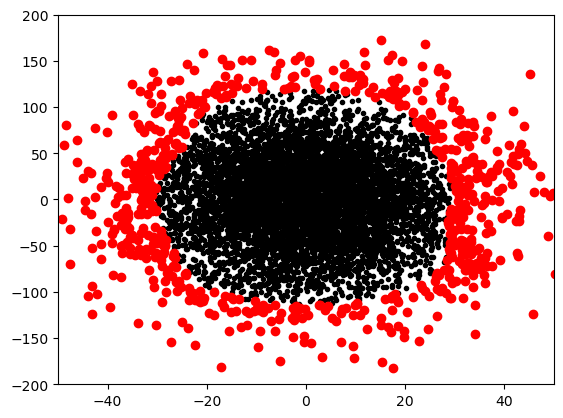

In [17]:
plt.plot(X_residual[:,0],X_residual[:,1],'k.')
plt.plot(X_residual[anomalies==1,0], X_residual[anomalies==1,1],'ro')
plt.xlim(-50,50)
plt.ylim(-200,200)

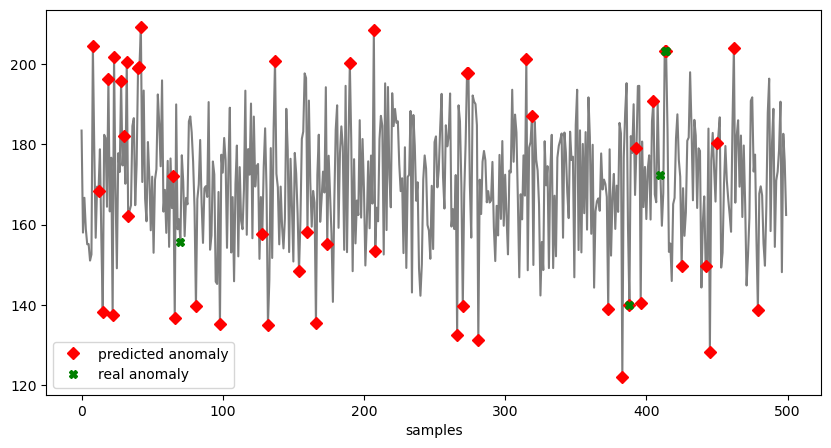

accuracy: 0.906
confusion matrix:
 [[450  45]
 [  2   3]]


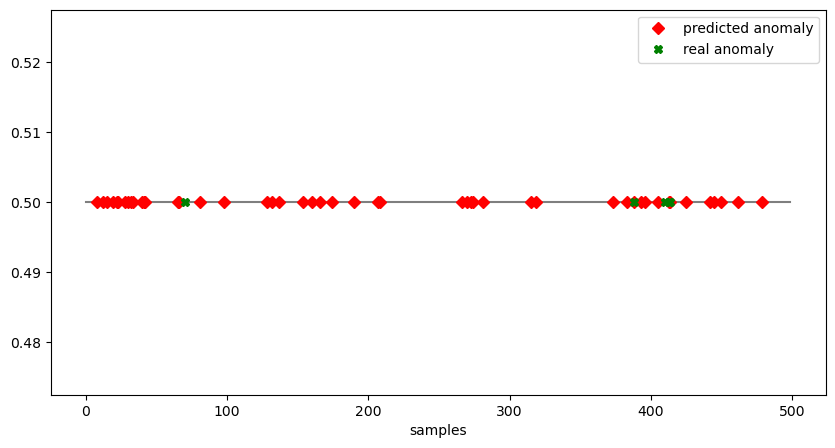

accuracy: 0.906
confusion matrix:
 [[450  45]
 [  2   3]]


In [18]:
#showing results
show_anomalies(volt[idx_split:], y[idx_split:], anomalies[idx_split:])
show_anomalies(vibration[idx_split:], y[idx_split:], anomalies[idx_split:])

## Version 3 with isolation Forest

In [19]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=float(0.05))
clf.fit(X_train[y_train==0])

IsolationForest(contamination=0.05)

In [20]:
anomalies = clf.predict(X_test)
anomalies = np.array([1 if _x < 0  else 0 for _x in anomalies]) 

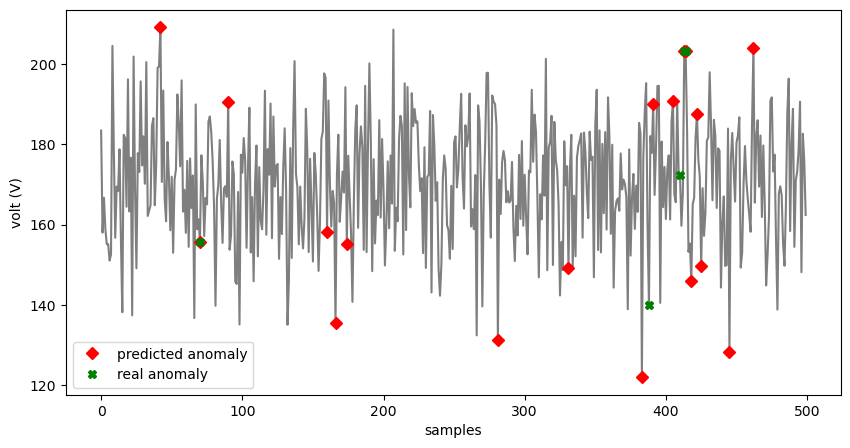

accuracy: 0.966
confusion matrix:
 [[480  15]
 [  2   3]]


In [21]:
show_anomalies(X_test[:,0], y_test, anomalies, title="volt (V)")

# PYOD

In [22]:
from pyod.models.inne import INNE
clf = INNE()
clf.fit(X_train)

INNE(contamination=0.1, max_samples='auto', n_estimators=200,
   random_state=None)

In [23]:
anomalies = clf.predict(X_test)
print(f'found {np.sum(anomalies)} anomalies')

found 43 anomalies


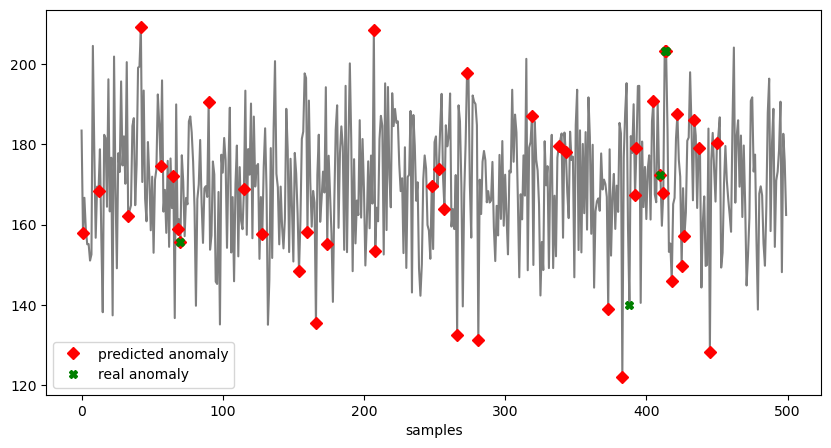

accuracy: 0.92
confusion matrix:
 [[456  39]
 [  1   4]]


In [24]:
show_anomalies(X_test[:,0], y_test, anomalies)